In [1]:
# %pip install --upgrade pip --user
# %pip install zarr --user
# %pip install tables --user
# %pip install git+https://github.com/simpeg/simpeg.git@simulation-tdem --user
# %pip install dask dask_jobqueue --user
# %pip install git+https://github.com/simpeg-research/casingSimulations.git@simulation --user

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import discretize
from scipy import sparse as sp
from scipy.constants import mu_0
import pandas as pd
from pymatsolver import Pardiso, SolverCG 
import os
import json
import dask
import dask_jobqueue
from dask.distributed import Client

import casingSimulations as casing_sim

import torch

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG.electromagnetics import time_domain as tdem

%matplotlib inline

In [2]:
Solver = Pardiso
solver_opts = {} #{"maxiter": 10}

In [3]:
data_directory = "./experiment1"
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

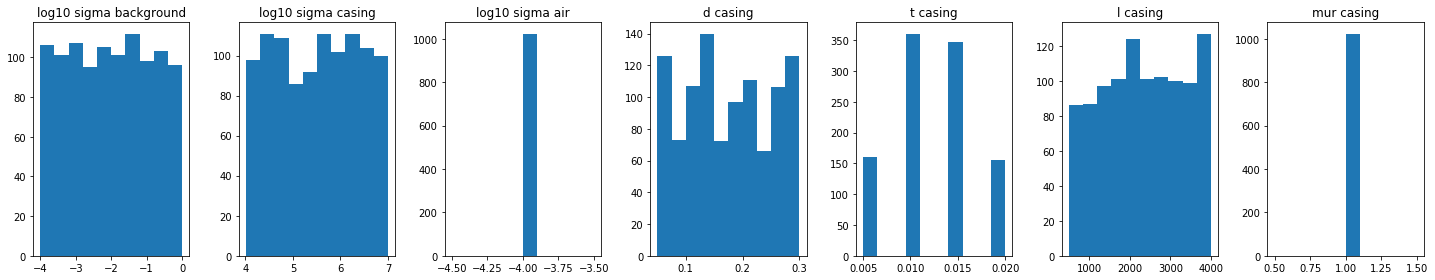

In [4]:
fig, ax = plt.subplots(1,len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [5]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [6]:
# generate the 2D model 

with open(f"{trial_directory}/approx_casing.json") as f: 
    params = json.load(f)
model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

with open(f"{trial_directory}/simulation_approx_casing.json") as f:
    simulation_params = json.load(f)
    
sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh3D = sim3D.mesh

In [40]:
# create a 2D simulation
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))


(-2000, 10)

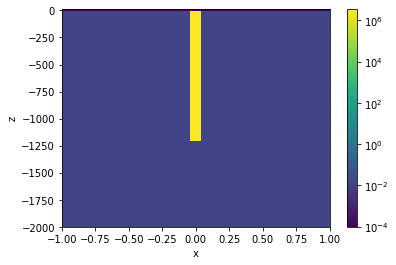

In [8]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    mesh.plotImage(
        sim.sigma, ax=ax, pcolorOpts={"norm":LogNorm()}, mirror=True
    )[0], ax=ax
)
ax.set_xlim([-1, 1])
ax.set_ylim([-2000, 10])

In [9]:
def getRHS(sim, src):
    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m

    # we are setting s_e to zero
    rhs = sim.mesh.edgeCurl * (sim.MeMuI * src)
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [10]:
def getRHS_deriv(sim, v=None, adjoint=False):

    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m
    # we are setting s_e to zero
    mesh = sim.mesh
    
    if adjoint:
        if sim._makeASymmetric:
            if v is not None: 
                rhs = sim.MfRho * v
            else:
                rhs = sim.MfRho
        else:
            rhs = v if v is not None else sp.eye(mesh.nF)
        return sim.MeMuI.T * (mesh.edgeCurl.T * rhs)
    
    if v is not None:
        rhs = sim.mesh.edgeCurl * (sim.MeMuI * v)
    else:
        rhs = sim.mesh.edgeCurl * sim.MeMuI
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [11]:
# solve the forward problem 
def fields(sim, source):
    f = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) >
            sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None

        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs = getRHS(sim, source[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs - Asubdiag * f[:, tInd])
        f[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return f

In [12]:
def fields_deriv(sim, v=None, adjoint=False):
    
    if adjoint:
        return fields_deriv_adjoint(sim, v=v)
    
    df_dm_v = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) > sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None
        
        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs_deriv = getRHS_deriv(sim, v[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs_deriv - Asubdiag * df_dm_v[:, tInd])
        df_dm_v[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return df_dm_v

In [13]:
def fields_deriv_adjoint(sim, v=None):
    
    df_dmT_v = np.zeros((sim.mesh.nE, sim.nT+1))  # the source is defined on edges

    # timestep to solve forward
    ATinv = None
    for tInd in reversed(range(sim.nT)):
        dt = sim.time_steps[tInd]
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if ATinv is not None and (
            tInd <= sim.nT and abs(dt-sim.timeSteps[tInd + 1]) > sim.dt_threshold
        ):
            ATinv.clean()
            ATinv = None
        
        if ATinv is None:
            AT = sim.getAdiag(tInd).T
            ATinv = Pardiso(AT)    
        
#         ATinv_v = ATinv * v[:, tInd+1]
        if tInd < sim.nT - 1:
            AsubdiagT = sim.getAsubdiag(tInd+1).T
            sol = ATinv * (v[:, tInd+1] - AsubdiagT * sol)
        else: 
            sol = ATinv * v[:, tInd+1]
        rhs_deriv = getRHS_deriv(sim, sol, adjoint=True)  # this is on the nodes of the time mesh
        
        df_dmT_v[:, tInd+1] = rhs_deriv

    # clean factors and return
    ATinv.clean()
    return df_dmT_v

In [14]:
def create_source(sim, model, s, trial_directory):
    # interpolate on to the spatial mesh (lets use exact time for now)
#     z_source = np.load(f"{trial_directory}/z_currents.npy")
    mesh = sim.mesh
    src = np.zeros((mesh.nEy, sim.nT+1))
  
    csx = mesh.hx.min()
    
    xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
    zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
    src_inds_bool = xinds & zinds
    src_inds = np.where(src_inds_bool)[0]
    
#     P = discretize.utils.interpmat(mesh.gridEy[src_inds, 2], z_source)

    src[src_inds, :] = s
    
    def grad(dy, adjoint=True):
        if adjoint:
            return dy[src_inds, :]
        grd = np.zeros((mesh.nEy, sim.nT+1))
        grd[src_inds, :] = dy
        return grd
    
    return src, grad
                  

In [15]:
def load_trial(trial_directory):
    
    # model parameters
    with open(f"{trial_directory}/casing.json") as f: 
        params = json.load(f)
    casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    approx_casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    model_dict = {
        "casing": casing, 
        "approx_casing": approx_casing
    }
    
    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.survey.source_list = sim.survey.source_list # HAck to trigger the validator 
    mesh = sim.mesh
    
    # load up the fields
    fields_dict = {}
    for key in model_dict.keys():
        print(key)
        sim.sigma = model_dict[key].sigma(mesh)
        f = np.load(f"{trial_directory}/{key}_fields.npy")
        fields_dict[key] = sim.fieldsPair(sim)
        fields_dict[key][:, "jSolution", :] = f
    
    return model_dict, fields_dict, sim, mesh 

In [124]:
tmp = np.vstack(np.atleast_2d([np.r_[1, 2, 3], np.r_[4, 5, 6]])).T
discretize.utils.mkvc(tmp)

array([1, 2, 3, 4, 5, 6])

In [125]:
np.kron(np.r_[True, True], np.r_[True, False, True])

array([ True, False,  True,  True, False,  True])

In [137]:
def get_j_inds(
    mesh, sim, x_bounds=np.r_[1, 2000], z_bounds=np.r_[-2000, 0]
):
  
    inds_Fx = (
        (mesh.gridFx[:, 0] > x_bounds.min()) & (mesh.gridFx[:, 0] < x_bounds.max()) &
        (mesh.gridFx[:, 2] > z_bounds.min()) & (mesh.gridFx[:, 2] < z_bounds.max()) 
    )
    
    inds_Fx = np.kron(np.ones(sim.nT+1, dtype=bool), inds_Fx)
    
    inds_Fz = (
        (mesh.gridFz[:, 0] > x_bounds.min()) & (mesh.gridFz[:, 0] < x_bounds.max()) &
        (mesh.gridFz[:, 2] > z_bounds.min()) & (mesh.gridFz[:, 2] < z_bounds.max()) 
    )
    inds_Fz = np.kron(np.ones(sim.nT+1, dtype=bool), inds_Fz)
    
    inds = np.hstack([inds_Fx, inds_Fz])

    return inds
    

In [36]:
def run_forward(model, mesh, sim, source_vec):
#     trial_directory = f"{data_directory}/trial_{trial_ind}"
#     model, mesh, sim = load_trial(trial_directory)
    
    source, source_grad = create_source(sim, model, source_vec, trial_directory)
    f = fields(sim, source)
#     P = get_j_interpolation_mat(trial_directory, mesh)
    j_compare = discretize.utils.mkvc(f)
    
    def grad(dy, adjoint=True):  
        if adjoint: 
            v = dy
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            f_deriv = fields_deriv_adjoint(sim, v)
            return source_grad(f_deriv, adjoint=True)
        f_deriv = fields_deriv(sim, source_grad(dy, adjoint=False))
        return discretize.utils.mkvc(f_deriv)
        
    return j_compare, grad

# set up a simple test example 

In [18]:
def waveform(t, t_peak=5e-3, width=10, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, dz=200, slope=1e-1):
    return sigmoid(z, model.casing_z.min() + dz, slope) * sigmoid(-z, -(model.casing_z.max() - dz), slope)

def source_sm(mesh, t, z):
    sm = np.zeros(mesh.nE)
    sm = np.outer(depth_distribution(z), waveform(t))
    
    return sm

In [103]:
# z = np.load(f"{trial_directory}/z_currents.npy")
csx = mesh.hx.min()
xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
src_inds_bool = xinds & zinds
src_inds = np.where(src_inds_bool)[0]
z = mesh.gridEy[src_inds, 2]

In [24]:
src_vec = source_sm(mesh, sim.times, z)

/usr/common/software/pytorch/v1.2.0-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'z')

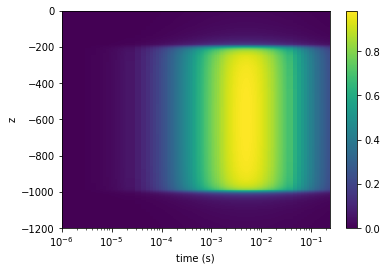

In [25]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, src_vec), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [29]:
def test_source(source):   
    source = source.reshape(len(z), sim.nT+1, order="F")
    src, grad = create_source(sim, model, source, trial_directory)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint: 
            dy = dy.reshape(len(z), sim.nT+1, order="F")
        else:
            dy = dy.reshape(mesh.nE, sim.nT+1, order="F")
        return discretize.utils.mkvc(grad(dy, adjoint))
    
    return discretize.utils.mkvc(src), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_source,
    x0=x0,
    num=4, 
    plotIt=False, 
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.154e+01     5.681e-15      nan
 1   1.00e-02    2.154e+00     4.701e-15      0.082
 2   1.00e-03    2.154e-01     4.658e-15      0.004
 3   1.00e-04    2.154e-02     4.662e-15      -0.000
========================= PASS! =========================
Go Test Go!



True

In [30]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(len(z), sim.nT+1, order="F"))
src, src_deriv = test_source(src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(mesh.nE*(sim.nT+1))

a = w.T.dot(discretize.utils.mkvc(src_deriv(v.reshape(len(z), sim.nT+1, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(src_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.157e+04, 1.157e+04, 3.638e-12


In [31]:
def test_rhs(source):   
    source = source.reshape(len(z), (sim.nT+1), order="F")
    src, grad_src = create_source(sim, model, source, trial_directory)
    rhs = getRHS(sim, src)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint:
            dy = dy.reshape(len(z), (sim.nT+1), order="F")
            return discretize.utils.mkvc(getRHS_deriv(sim, grad_src(dy, adjoint), adjoint))
        else: 
            dy = dy.reshape(mesh.nF, (sim.nT+1), order="F")
            return grad_src(getRHS_deriv(sim, dy, adjoint), adjoint)        
    
    return discretize.utils.mkvc(rhs), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_rhs,
    x0=x0,
#     dx=1e-3*x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.481e+12     2.995e-04      nan
 1   1.00e-02    1.481e+11     1.582e-04      0.277
 2   1.00e-03    1.481e+10     1.571e-04      0.003
 3   1.00e-04    1.481e+09     1.560e-04      0.003
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Thankfully,  persistence is a great substitute for talent.



False

In [32]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(len(z), sim.nT+1, order="F"))
rhs, rhs_deriv = test_rhs(src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(mesh.nF*(sim.nT+1))

a = w.T.dot(discretize.utils.mkvc(rhs_deriv(v.reshape(len(z), (sim.nT+1), order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(rhs_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.181e+14, 1.181e+14, 1.562e-02


In [33]:
src_sm, _ = create_source(sim, model, src_vec.reshape(len(z), sim.nT+1, order="F"), trial_directory)

def test_forward(src_sm):
    src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
    j = fields(sim, src_sm)
    
    def j_deriv(v, adjoint=False):
        if not adjoint:
            v = v.reshape(mesh.nEy, sim.nT+1, order="F")
            return discretize.utils.mkvc(fields_deriv(sim, v, adjoint))
        else:
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            return fields_deriv(sim, v, adjoint)
    return discretize.utils.mkvc(j), j_deriv

x0 = discretize.utils.mkvc(src_sm)
discretize.Tests.checkDerivative(
    test_forward,
    x0=x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/global/homes/l/lheagy/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


 0   1.00e-01    3.827e+08     2.128e-03      nan
 1   1.00e-02    3.827e+07     1.253e-03      0.230
 2   1.00e-03    3.827e+06     2.318e-03      -0.267
 3   1.00e-04    3.827e+05     2.377e-03      -0.011
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
You break it, you fix it.



False

In [34]:
# adjoint test

j, j_deriv = test_forward(src_sm)

v = np.random.rand(np.prod(src_sm.shape))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v, adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

7.369e+11, 7.369e+11, 1.807e-01


In [ ]:
model_dict, fields_dict, sim3D, mesh3D = load_trial(trial_directory)

In [42]:
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))

def test_forward_full(src_vec):
    src_vec = src_vec.reshape(len(z), sim.nT+1, order="F")
    j, j_deriv = run_forward(model_dict["approx_casing"], mesh, sim, src_vec)
    
    def grad(v):
        v = v.reshape(len(z), sim.nT+1, order="F")
        return discretize.utils.mkvc(j_deriv(v, adjoint=False))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_forward_full,
    x0=x0,
    num=5, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.271e+05     9.701e-04      nan
 1   1.00e-02    3.271e+04     8.418e-04      0.062
 2   1.00e-03    3.271e+03     2.931e-03      -0.542
 3   1.00e-04    3.271e+02     8.517e-04      0.537
 4   1.00e-05    3.271e+01     7.455e-04      0.058
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
No gold star for you.



False

In [45]:
# adjoint test

src_vec = src_vec.reshape(len(z), sim.nT+1, order="F")
j, j_deriv = run_forward(model_dict["approx_casing"], mesh, sim, src_vec)

v = np.random.rand(len(z)*(sim.nT+1))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v.reshape(len(z), sim.nT+1, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

err = a-b
if np.linalg.norm(err)/np.linalg.norm(a) < 1e-10:
    passing = True
else: 
    passing = False
    
print(
    f"{np.linalg.norm(a):1.3e}, "
    f"{np.linalg.norm(b):1.3e}, "
    f"{np.linalg.norm(err):1.3e}, "
    f"{'passing :)' if passing is True else 'failing :('}"
)

8.558e+09, 8.558e+09, 9.918e-03, passing :)


In [47]:
def test_sanity_check(src_vec):
#     src_vec = src_vec.reshape(128, 2, order="F")
    A = np.random.randn(len(z), len(z))
    bigA = sp.block_diag([A, A])
    j = bigA.dot(src_vec)
    
    def grad(v):
#         v = v.reshape(128, 2, order="F")
        return discretize.utils.mkvc(bigA.dot(v))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec[:, 0:2])
discretize.Tests.checkDerivative(
    test_sanity_check,
    x0=x0,
    num=10, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.476e+01     5.058e+01      nan
 1   1.00e-02    3.601e+00     4.897e+00      1.014
 2   1.00e-03    4.570e-01     5.937e-01      0.916
 3   1.00e-04    2.852e-01     2.878e-01      0.315
 4   1.00e-05    2.903e-01     2.907e-01      -0.004
 5   1.00e-06    2.788e-01     2.788e-01      0.018
 6   1.00e-07    2.883e-01     2.883e-01      -0.014
 7   1.00e-08    2.900e-01     2.900e-01      -0.003
 8   1.00e-09    3.133e-01     3.133e-01      -0.034
 9   1.00e-10    3.033e-01     3.033e-01      0.014
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Get on it Lheagy!



False

In [48]:
src_sm, _ = create_source(sim, model, src_vec, trial_directory)
src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
j = fields(sim, src_sm)

Text(0.5, 1.0, 'current density, t=1.2e-01ms')

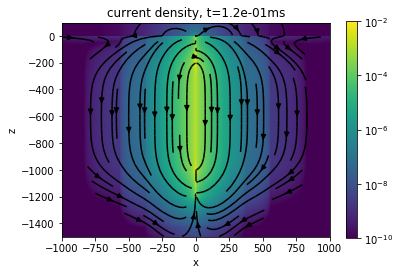

In [49]:
tind = 30
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 100],
    sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-10, 1e-2], 
    stream_threshold = 1e-10
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={sim.times[tind]*1e3:1.1e}ms")

Text(0.5, 1.0, 'source term, t=1.0e-02ms')

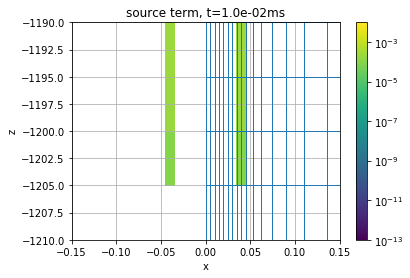

In [50]:
tind = 10
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveE2CC * src_sm[:, tind], 
#     view="vec",
#     vType="CCv",
    ax=ax, mirror=True,
    range_x=0.15*np.r_[-1, 1], 
    range_y=np.r_[-1210, -1190], #10*np.r_[-1, 1],
#     sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-13, 1e-2], 
#     stream_threshold = 1e-13
)
mesh.plotGrid(ax=ax)
# ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"source term, t={sim.times[tind]*1e3:1.1e}ms")

# Set up ML pipeline

In [56]:
dtype = torch.float64
device = torch.device("cpu")

In [51]:
nspatial = len(z)
ntimes = sim.nT + 1
nsrcz = len(z)

In [155]:
class ForwardSimulation(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, source_vec): #, trial_ind):
#         trial_ind = tri
#         trial_directory = f"{data_directory}/trial_{trial_ind}"
        
        # load up objects 
#         model, mesh, sim = load_trial(trial_directory)
        
        ctx.model = model
        ctx.mesh = mesh
        ctx.sim = sim

        # create source 
        source, source_grad = create_source(sim, model, source_vec.data.numpy(), trial_directory)
        rhs = getRHS(sim, source)
        
        ctx.source_grad = source_grad
        
        # compute fields 
        f = fields(sim, source)
        
        if getattr(ctx, 'P', None) is None:
            inds = inds = get_j_inds(
                mesh, sim, x_bounds=np.r_[1, 2000], z_bounds=np.r_[-2000, 0]
            )
            ctx.inds = inds
        
        # project data
        j_compare = (discretize.utils.mkvc(f))[inds]
        
        if dtype == torch.float32:
            return torch.from_numpy(j_compare).float()
        return torch.from_numpy(j_compare).double()

    @staticmethod
    def backward(ctx, dy): 
        inds = ctx.inds
        v = np.zeros(ctx.mesh.nF*(ctx.sim.nT+1))
        v[inds] = dy.data.numpy()
        v = v.reshape(ctx.mesh.nF, ctx.sim.nT+1, order="F")
        f_deriv = fields_deriv_adjoint(ctx.sim, v)
        grad = ctx.source_grad(f_deriv, adjoint=True)

        if dtype == torch.float32:
            return torch.from_numpy(grad).float()
        return torch.from_numpy(grad).double()



In [156]:
# class CasingData(torch.utils.data.Dataset):
#     def __init__(self, directory, trial_indices):
#         self.directory = directory
#         self.trial_indices = trial_indices
        
#     def __len__(self):
#         return len(self.trial_indices)
    
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
        
        

In [157]:
# source, source_deriv = create_source(sim, model, src_vec, trial_directory)
# rhs = getRHS(sim, source)

# trial_ind = 10
# trials = [trial_ind]

# jd_numpy = np.load(f"{trial_directory}/j_difference.npy")

In [158]:
# plt.hist(np.log10(np.abs(jd_numpy)), 20);

In [159]:
jd_numpy3D = fields_dict["casing"][:, "j", :] - fields_dict["approx_casing"][:, "j", :]

In [160]:
jd_x = (jd_numpy3D[:mesh3D.nFx, :]).reshape(np.hstack([mesh3D.vnFx, np.r_[sim.nT+1]]), order="F")
jd_z = (jd_numpy3D[mesh3D.vnF[:2].sum():, :]).reshape(np.hstack([mesh3D.vnFz, np.r_[sim.nT+1]]), order="F")

# grab a slice through theta
theta_ind = 3
jd_numpy = np.hstack([
    discretize.utils.mkvc(jd_x[:, theta_ind, :, :]),
    discretize.utils.mkvc(jd_z[:, theta_ind, :, :]),
])

# select inds away from the well 
inds = get_j_inds(
    mesh, sim, x_bounds=np.r_[1, 2000], z_bounds=np.r_[-2000, 0]
)
jd_numpy = jd_numpy[inds]

In [162]:
def convert_to_torch_sparse(mat):
    mat = mat.tocoo()
    
    values = mat.data
    indices = np.vstack((mat.row, mat.col))

    # create pytorch sparse matrix
    i = torch.LongTensor(indices)
    
    if dtype == torch.float32: 
        v = torch.FloatTensor(values)
    else:
        v = torch.DoubleTensor(values)
    shape = mat.shape
    
    if dtype == torch.float32: 
        return torch.sparse.FloatTensor(i, v, torch.Size(shape))
    return torch.sparse.DoubleTensor(i, v, torch.Size(shape))

In [163]:
Dtime = discretize.utils.sdiag(1./sim.time_mesh.hx) * discretize.utils.ddx(sim.nT)
Dtime_torch = convert_to_torch_sparse(Dtime)

# z_currents = np.load(f"{trial_directory}/z_currents.npy")
Dz = discretize.utils.sdiag(1./np.diff(z)) * discretize.utils.ddx(len(z)-1)
Dz_torch = convert_to_torch_sparse(Dz)

In [224]:
floor = 1e-12
print((np.abs(jd_numpy)>floor).sum() / len(jd_numpy))

0.8483790905082198


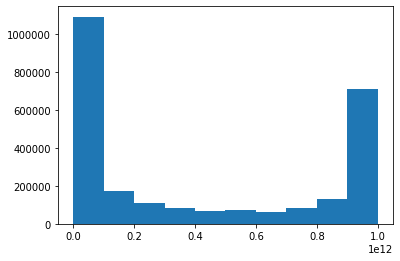

In [235]:
jd = torch.from_numpy(jd_numpy)

std = 0.02 
w = torch.from_numpy(1./(std * np.abs(jd_numpy) + floor))

forward = ForwardSimulation.apply

if dtype == torch.float64:
    jd = jd.double()
    w = w.double() 
else:
    jd = jd.float()
    w = w.float()
    
s0_scaling = 1 #1e-5
learning_rate = 1 #1e-3

plt.hist(1./(std * np.abs(jd_numpy) + floor));
# optimizer = torch.optim.SGD(s0, lr=learning_rate)

In [242]:
# %%time
max_iter = 20
beta = None
beta_factor = 0 #10
# beta_cooling = 0.5

alpha_s = 1e-4
alpha_t = sim.time_mesh.hx.min()**2
alpha_z = 1

s0 = torch.zeros(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)

if beta is None:
    s0_tmp = torch.randn(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)
    j_pred = forward(s0_scaling * s0_tmp)
#     dmisfit = 1/len(jd) * (w*(j_pred - jd)).pow(2).sum()
    dmisfit = ((j_pred - jd)).pow(2).sum()
    regularization = (
        alpha_s * s0_tmp.pow(2).sum() + 
        alpha_t * Dtime_torch.mm(s0_tmp.T).pow(2).sum() + 
        alpha_z * Dz_torch.mm(s0_tmp).pow(2).sum()
    )
    beta = beta_factor * dmisfit.item() / regularization.item()

for i in range(max_iter):
    s_iter = s0_scaling * s0
    j_pred = forward(s_iter)
#     dmisfit = 1/len(jd) * (w*(j_pred - jd)).pow(2).sum()
    dmisfit = ((j_pred - jd)).pow(2).sum()
    smallness = alpha_s * s0.pow(2).sum()
    smooth_time = alpha_t * Dtime_torch.mm(s0.T).pow(2).sum()
    smooth_depth = alpha_z * Dz_torch.mm(s0).pow(2).sum()
    
    regularization = (
        smallness + 
        smooth_time + 
        smooth_depth
    )
    
    loss = dmisfit + beta * regularization
    
    print(
        f"iter {i}, "
        f"dmisfit: {dmisfit.item():1.4e}, "
        f"reg: {regularization.item():1.4e}, "
        f"beta * reg: {beta * regularization.item():1.4e}, "
        f"loss: {loss.item():1.4e}"
    )
    
    print(
        f"    small: {smallness.item():1.4e}, "
        f"smooth time: {smooth_time.item():1.4e}, "
        f"smooth depth: {smooth_depth.item():1.4e}\n"
    )
    
#     optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    with torch.no_grad():
        s0 -= learning_rate * s0.grad
        s0.grad.zero_()
    
#     beta = beta_cooling * beta

iter 0, dmisfit: 1.3322e-08, reg: 0.0000e+00, beta * reg: 0.0000e+00, loss: 1.3322e-08
    small: 0.0000e+00, smooth time: 0.0000e+00, smooth depth: 0.0000e+00

iter 1, dmisfit: 1.3141e-08, reg: 2.3371e-13, beta * reg: 0.0000e+00, loss: 1.3141e-08
    small: 1.8491e-14, smooth time: 1.8202e-13, smooth depth: 3.3198e-14

iter 2, dmisfit: 1.2971e-08, reg: 9.2744e-13, beta * reg: 0.0000e+00, loss: 1.2971e-08
    small: 7.1456e-14, smooth time: 7.2497e-13, smooth depth: 1.3102e-13

iter 3, dmisfit: 1.2811e-08, reg: 2.0709e-12, beta * reg: 0.0000e+00, loss: 1.2811e-08
    small: 1.5557e-13, smooth time: 1.6243e-12, smooth depth: 2.9098e-13

iter 4, dmisfit: 1.2661e-08, reg: 3.6547e-12, beta * reg: 0.0000e+00, loss: 1.2661e-08
    small: 2.6799e-13, smooth time: 2.8759e-12, smooth depth: 5.1081e-13

iter 5, dmisfit: 1.2519e-08, reg: 5.6702e-12, beta * reg: 0.0000e+00, loss: 1.2519e-08
    small: 4.0625e-13, smooth time: 4.4755e-12, smooth depth: 7.8841e-13

iter 6, dmisfit: 1.2385e-08, reg: 

Text(0, 0.5, 'z')

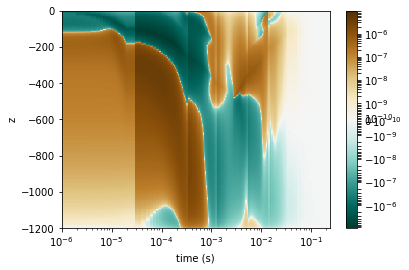

In [243]:
fig, ax = plt.subplots(1, 1)

# z = np.load(f"{trial_directory}/z_currents.npy")
plotme = s0_scaling * s0.data.numpy()
clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )
    
plt.colorbar(ax.pcolormesh(sim.times, z, plotme, cmap="BrBG_r", norm=norm), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [238]:
# load up objects 
# model, mesh, sim = load_trial(trial_directory)
src, _ = create_source(sim, model, s0.data.numpy(), trial_directory)

(-2000, 50)

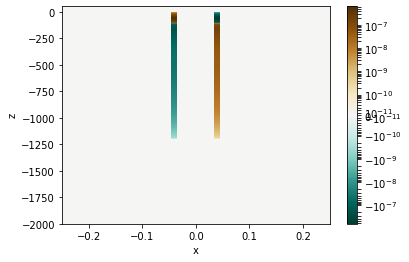

In [239]:
tind = 10
plotme = mesh.aveE2CC * src[:, tind]

clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )

fig, ax = plt.subplots(1, 1)
plt.colorbar(mesh.plotImage(
    plotme, 
    mirror=True, 
    mirror_data=-1*plotme,
    pcolorOpts={"norm": norm, "cmap": "BrBG_r"},
    ax=ax
)[0], ax=ax)

ax.set_xlim(0.25*np.r_[-1, 1])
ax.set_ylim(np.r_[-2000, 50])

In [240]:
j_rec = fields(sim, src)

model_names = list(model_dict.keys())
# sim.survey.source_list = sim.survey.source_list
viewer = casing_sim.FieldsViewer(
    mesh=mesh3D, model_parameters_dict=model_dict, survey_dict={key: sim3D.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

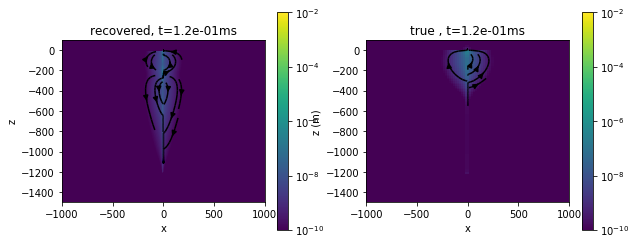

In [241]:
tind = 30
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlim = np.r_[-1000, 1000]
zlim = np.r_[-1500, 100]
sample_grid = np.r_[5., 5.]
clim = np.r_[1e-10, 1e-2]

out = mesh.plotImage(
    mesh.aveF2CCV * j_rec[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax[0], mirror=True,
    range_x=xlim, 
    range_y=zlim,
    sample_grid = sample_grid,
    pcolorOpts={"norm":LogNorm()},
    clim=clim, 
    stream_threshold=clim.min()
)

plt.colorbar(out[0], ax=ax[0])

ax[0].set_title(f"recovered, t={sim.times[tind]*1e3:1.1e}ms")


out2 = viewer.plot_cross_section(
    ax=ax[1], clim=clim, zlim=zlim,
    xlim=xlim,
    view='j', theta_ind=3, time_ind=tind, 
    model_key='approx_casing', show_cb=True, casing_outline=False,
    prim_sec="secondary"
#     stream_opts={"density":0.75, "color": "k", "arrowsize": 2}
)
# ax[1].set_ylim(np.r_[-max_depth, top])
ax[1].set_ylabel('z (m)')
ax[1].set_title(f"true , t={sim.times[tind]*1e3:1.1e}ms")

for a in ax:
    a.set_aspect(1)

In [7]:
import numpy as np

In [8]:
def random_vec(n):
    return np.random.rand(n)

In [9]:
np.random.seed(1)
random_vec(1)

array([0.417022])

In [10]:
random_vec(1)

array([0.72032449])